# Quantum Natural Gradient

Author(s): Kyle Godbey

Maintainer: Kyle Godbey

For this last application, let's think of a way to improve our VQE algorithm by exploiting some features of our quantum computing architecture. What we'll do is, instead of computing the gradient of the variational parameters of our ansatz, we'll instead compute the so-called Quantum Natural Gradient. This is an extension of the standard natural gradient which moves in the steepest descent direction of the information geometry, using something like the Fisher metric. For these quantum systems, we'll instead use the Fubini-Study metric (real part of the quantum geometric tensor) to determine the most optimal step in the ansatz parameters. For more details you should have a look at the [Quantum Natural Gradient](https://quantum-journal.org/papers/q-2020-05-25-269/) paper published in 2020.

While it's not too difficult to calculate this measure yourself by constructing the Hessian using [parameter shift rules](https://pennylane.ai/qml/glossary/parameter_shift.html), we'll be using a built in pennylane method to make our lives easier. 

Most of this will be the same as the N=3 case, so we'll toss it all in a cell together -- be sure to check that you know what's happening though!

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

# In this case we now need 3 qubits

dev = qml.device("default.qubit", wires=3)

# Defining our ansatz circuit for the N=3 case

def circuit(params,wires):
    t0 = params[0]
    t1 = params[1]
    qml.PauliX(wires=0)
    qml.RY(t1, wires=1)
    qml.RY(t0, wires=2)
    qml.CNOT(wires=[2,0])
    qml.CNOT(wires=[0,1])
    qml.RY(-t1, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])

# And building our Hamiltonian for the N=3 case

coeffs = [15.531709 ,-2.1433, -2.1433, 0.21829, -6.125, -9.625, -3.91, -3.91]
obs = [qml.Identity(0),qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1),qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliX(1) @ qml.PauliX(2),qml.PauliY(1) @ qml.PauliY(2)]

H = qml.Hamiltonian(coeffs, obs)
cost_fn = qml.ExpvalCost(circuit, H, dev)


Now we'll still set up what we need for our VQE procedure, but we'll be running it twice, so setting the initial parameters is a necessity for the sake of fairness.

In [3]:
# Hand-picked, small-batch initialization

init_params = np.array([2.5,4.5])

# Convergence information and step size

max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

For the VQE block, we'll run two one after another. First up is the same thing we had before, good ol' gradient descent.

In [9]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 22.73185830 MeV,  Convergence parameter = 0.16533643 MeV
Iteration = 20,  Energy = 13.86733622 MeV,  Convergence parameter = 0.85950160 MeV
Iteration = 40,  Energy = 0.66226895 MeV,  Convergence parameter = 0.41277410 MeV
Iteration = 60,  Energy = -1.94958676 MeV,  Convergence parameter = 0.01827050 MeV
Iteration = 80,  Energy = -2.04226133 MeV,  Convergence parameter = 0.00054725 MeV
Iteration = 100,  Energy = -2.04502496 MeV,  Convergence parameter = 0.00001629 MeV

Final value of the energy = -2.04510468 MeV
Number of iterations =  116


Looks the same as before, that's a good sign. Now let's try the QNG!

In [7]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params

qng_param_history = [params]
qng_cost_history = []

for n in range(max_iterations):

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    qng_param_history.append(params)
    qng_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 22.30149608 MeV,  Convergence parameter = 0.59569865 MeV
Iteration = 20,  Energy = -2.03927628 MeV,  Convergence parameter = 0.00595511 MeV

Final value of the energy = -2.04510917 MeV
Number of iterations =  33


Very nice! We sped things up a good bit, but let's check the convergence plot to see the behavior over the iterations.

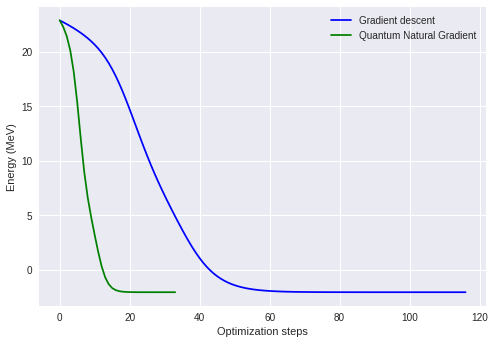

In [11]:
plt.style.use("seaborn")

plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qng_cost_history, "g", label="Quantum Natural Gradient")

plt.ylabel("Energy (MeV)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Wow! It seems taking a more intelligent step in parameter space can work wonders towards finding an optimal solution. This works much better than simply adding a variable time step, like we did for the general case. Try implementing the QNG optimizer for higher dimensions and check the performance!

Finally, we can plot how we trace the potential energy surface (PES) as we find a solution. It's a little more exciting now that we have two paths -- let's imagine they're racing through the mountains.

If you're running this yourself, you can either generate the surface yourself or put this code in a cell to download it locally:

`!wget https://github.com/kylegodbey/nuclear-quantum-computing/raw/main/nuclear-qc/vqe/deut_pes_n3.npy`

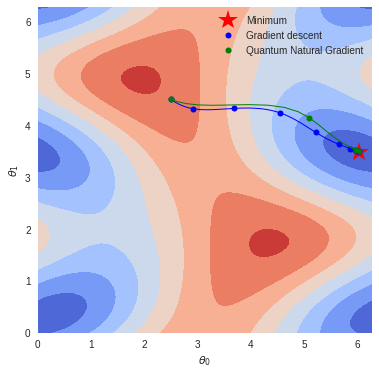

In [13]:
# Discretize the parameter space
theta0 = np.linspace(0.0, 2.0 * np.pi, 100)
theta1 = np.linspace(0.0, 2.0 * np.pi, 100)

# Load energy value at each point in parameter space
pes = np.load("deut_pes_n3.npy")

# Get the minimum of the PES
minloc=np.unravel_index(pes.argmin(),pes.shape)

# Plot energy landscape
fig, axes = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta0, theta1, pes.T, cmap=cmap)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")

plt.plot(theta0[minloc[0]],theta1[minloc[1]],"r*",markersize=20,label="Minimum")

# Plot optimization path for gradient descent. Plot every 10th point.
gd_color = "b"

plt.plot(
    np.array(gd_param_history)[::10, 0],
    np.array(gd_param_history)[::10, 1],
    ".",markersize=12,
    color=gd_color,
    linewidth=2,
    label="Gradient descent",
)
plt.plot(
    np.array(gd_param_history)[:, 0],
    np.array(gd_param_history)[:, 1],
    "-",
    color=gd_color,
    linewidth=1,
)

# Plot optimization path for qng. Plot every 10th point.
qng_color = "g"

plt.plot(
    np.array(qng_param_history)[::10, 0],
    np.array(qng_param_history)[::10, 1],
    ".",markersize=12,
    color=qng_color,
    linewidth=2,
    label="Quantum Natural Gradient",
)
plt.plot(
    np.array(qng_param_history)[:, 0],
    np.array(qng_param_history)[:, 1],
    "-",
    color=qng_color,
    linewidth=1,
)

plt.legend()
plt.show()

You can see that the paths are not massively different, but the QNG results in a much sharper gradient in the parameter space. Exemplified by the spacing between the points along the line, showing the value every ten time steps. This steeper landscape leads to bigger steps towards the minimum without risking overshooting, making it an excellent fit in situations where you can make use of it!

This concludes our exploration of playing with VQE ad nauseam, next up we'll explore what happens when things get a bit more noisy.